# File paths

In [24]:
TrainingCSVPath = r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Training_landmarks.csv"
ValidationCSVPath = r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Validation_landmarks.csv"
TestCSVPath = r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test_landmarks.csv"
TestImagesPath = r"C:\Users\leons\Documents\DeepLearning\DatasetForFingerCounter\Test"

# Imports

In [17]:
!pip install --upgrade pip

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" #get rid of TF log messages

!pip install numpy
import numpy as np

# pandas for handling csv (pyarrow required for pandas)
!pip install pyarrow 
!pip install pandas
import pandas as pd

from glob import glob

!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical # needed to one-hot encode labels
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# keras-tuner for hyperparameter tuning
!pip install keras-tuner
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time

# for plotting
!pip install matplotlib
import matplotlib.pyplot as plt

# for confusion matrix
!pip install scikit-learn
!pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Preprocessing

In [23]:
class_names = ["zero", "one", "two", "three", "four", "five", "spock", "other"]

""" Paths """
model_path = os.path.join("files", "model.keras") # is created while training
csv_path = os.path.join("files", "data.csv") # is created while training

""" Seed the environment """
np.random.seed(42)
tf.random.set_seed(42)

""" Create blank folders """
def create_dir(path):
    os.makedirs(path, exist_ok=True)

""" Extract labels and features from CSV """
def load_and_preprocess_dataset(file_path):
    landmarks_file = pd.read_csv(file_path, header=0)
    
    features = landmarks_file.drop('filename', axis=1)

    labels = landmarks_file.pop('filename')
    
    labels = [label.split('_')[2] for label in labels]

    # convert string labels to integer labels
    labels = np.array([class_names.index(label) for label in labels])

    features_array = np.array(features).reshape(-1, 21, 3)
    
    return features_array, labels


""" Directory for storing files """
create_dir("files")


""" Load datasets """
batch_size = 32 #batch size can be changed to which fits best for hardware
train_features, train_labels = load_and_preprocess_dataset(TrainingCSVPath)
valid_features, valid_labels = load_and_preprocess_dataset(ValidationCSVPath)
test_features, test_labels = load_and_preprocess_dataset(TestCSVPath)

# Building and training the model

In [12]:
""" Build model with Hyperparameters """
def build_model(hp):  
    model = keras.Sequential()

    # input layer
    model.add(layers.Flatten(input_shape=(21, 3))) # make 1 dimensional array out of 21x3 array
    
    for i in range(hp.Int('num_layers', 1, 4)): # tune number of hidden layers
        model.add(layers.Dense(units=hp.Int('units_' + str(i), # dense = every input neuron is connected to every next neuron
                                            min_value=64,
                                            max_value=1024,
                                            step=32), # tune number of neurons; value is between 64 and 1024 in steps of 32
                               activation='relu'))
        
    # tune whether to use dropout
    if hp.Boolean("dropout"):
      model.add(layers.Dropout(rate=0.2))

    # output layer
    model.add(layers.Dense(8, activation="softmax")) # softmax = probability of all output neurons add up to 1

    # tune learning rate 
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    #learning_rate = 1e-3 # 1e-3 = 0.001
    
    model.compile(loss="sparse_categorical_crossentropy", 
                  #optimizer="adam",
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"]
    )
    
    return model

""" Logging and early stopping """
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    CSVLogger(csv_path, append=True),
    # if within 30 epochs the val_accuracy does not increase, the model will stop training
    EarlyStopping(monitor='val_accuracy', mode='max', patience=30)
]

""" Define how to search for best model """
tuner = RandomSearch(
    hypermodel=build_model,
    objective = 'val_accuracy', # search for model with highest val accuracy
    max_trials = 30, # total number of trials to run during search; should be as high as all combinations possible; default is 10
    executions_per_trial = 2, # number of models that should be built and fit for each trial; executions within trial have same hyperparameter values
    directory='output', # where to store search results
    overwrite = True # overwrite previous results in same directory
)

""" Train models with different hyperparameter configurations and save best """
tuner.search(
    x = train_features,
    y = train_labels,
    epochs = 300,
    batch_size = 32,
    validation_data = (valid_features, valid_labels),
    callbacks=callbacks
)

""" Extract and print best hyperparameter configuration and result summary """
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("----------------------------------------------------")
print("best values:")
print(best_hps.values)
print("----------------------------------------------------")
tuner.results_summary()


""" Build model with optimal hyperparameters and train it for 300 epochs """
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x = train_features,
    y = train_labels,
    epochs = 300,
    batch_size = 32,
    validation_data = (valid_features, valid_labels)
    #callbacks=callbacks
)

""" Determine best amount of epochs for val accuarcy from previousely trained model """
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1   # epoch with higest val accuracy


""" Again build model with optimal hyperparameters and train it for previousely determined amount of epochs """
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(
    x = train_features,
    y = train_labels,
    epochs = best_epoch,
    batch_size = 32,
    validation_data = (valid_features, valid_labels)
    #callbacks=callbacks     no early stoppage needed
)


""" Test the model """
evaluation = hypermodel.evaluate(test_features, test_labels)

Trial 30 Complete [00h 01m 34s]
val_accuracy: 0.9779411852359772

Best val_accuracy So Far: 0.9901960790157318
Total elapsed time: 00h 47m 23s
----------------------------------------------------
best values:
{'num_layers': 2, 'units_0': 288, 'units_1': 160, 'dropout': True, 'units_2': 64}
----------------------------------------------------
Results summary
Results in output\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
num_layers: 2
units_0: 288
units_1: 160
dropout: True
units_2: 64
Score: 0.9901960790157318

Trial 17 summary
Hyperparameters:
num_layers: 3
units_0: 352
units_1: 384
dropout: False
units_2: 384
Score: 0.987745076417923

Trial 26 summary
Hyperparameters:
num_layers: 2
units_0: 128
units_1: 256
dropout: True
units_2: 64
Score: 0.987745076417923

Trial 14 summary
Hyperparameters:
num_layers: 2
units_0: 480
units_1: 96
dropout: False
units_2: 384
Score: 0.9852941036224365

Trial 19 summary
Hyperpa

# Plotting results

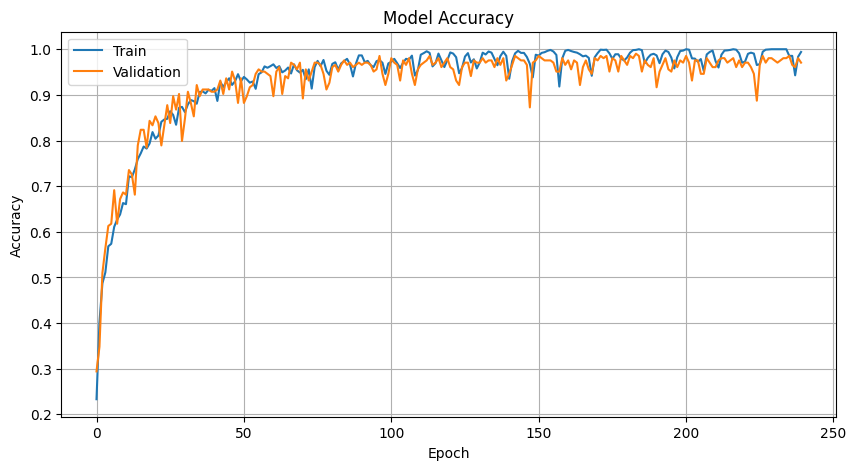

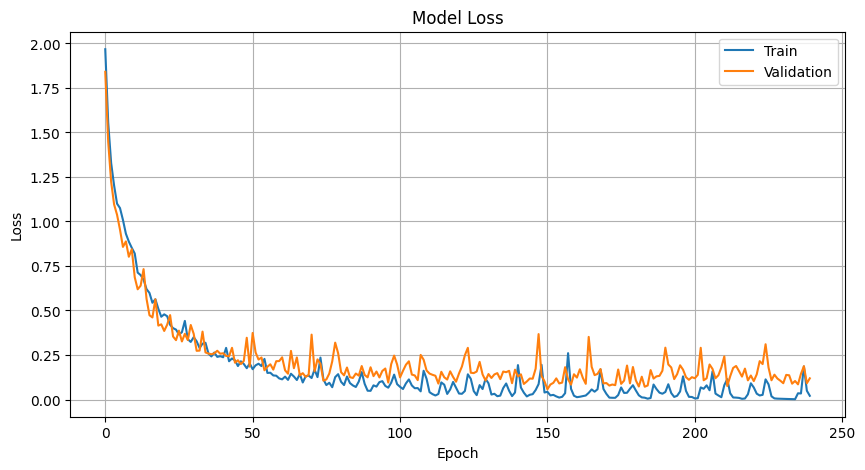

In [7]:
""" Accuracy """
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

""" Loss """
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix and display of misclassified data

7/7 [==============================] - 0s 1ms/step


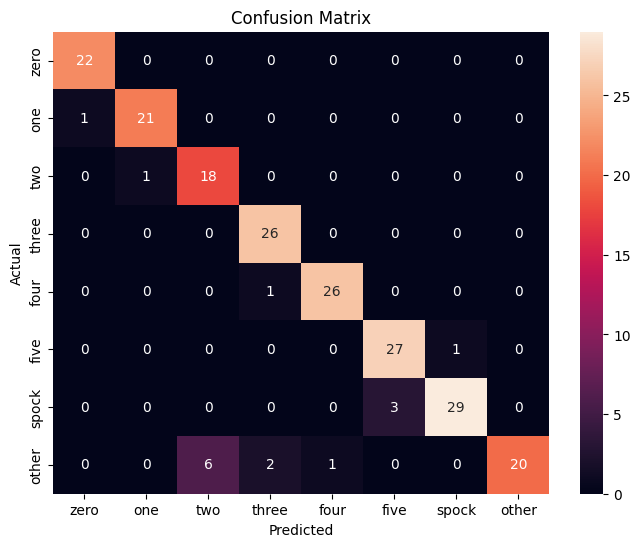

   ACTUAL LABEL PREDICTED LABEL         FILE NAME OF IMAGE
0          four           three     Alex_image_four_27.jpg
1           one            zero      Alex_image_one_48.jpg
2         spock            five    Alex_image_spock_22.jpg
3         spock            five    Alex_image_spock_37.jpg
4          five           spock  Dominik_image_five_77.jpg
5           two             one    Henrik_image_two_37.jpg
6         other             two     Leon_image_other_1.jpg
7         other             two    Leon_image_other_14.jpg
8         other             two    Leon_image_other_15.jpg
9         other             two    Leon_image_other_16.jpg
10        other           three    Leon_image_other_39.jpg
11        other             two    Leon_image_other_44.jpg
12        other            four    Leon_image_other_55.jpg
13        other           three    Leon_image_other_78.jpg
14        other             two     Leon_image_other_8.jpg
15        spock            five    Leon_image_spock_72.j

In [8]:
""" Predict with test set and create confusion matrix """
predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(test_labels, predicted_labels) # create confusion matrix
# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



""" Display mislassified data """
incorrect_indices = np.where(test_labels != predicted_labels)[0] 
# Read the first row of the test dataset CSV file to get file names
test_file_names = pd.read_csv(TestCSVPath, usecols=[0]).values.flatten()

# one dimensional array which contains file names of misclassified files
incorrect_files = np.array(test_file_names)[incorrect_indices] 

# Create a DataFrame for misclassified images
data = {
    'ACTUAL LABEL': [class_names[test_labels[i]] for i in incorrect_indices],
    'PREDICTED LABEL': [class_names[predicted_labels[i]] for i in incorrect_indices],
    'FILE NAME OF IMAGE': incorrect_files
}
incorrect_df = pd.DataFrame(data)
print(incorrect_df)

# Check misclassified data: draw corresponding landmarks from CSV on the images concerned and save them

In [25]:
""" Mediapipe is needed to create landmark objects """
!pip install opencv-python
import cv2
!pip install mediapipe==0.10.8 
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2 
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

output_folder = "wrong_images"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

""" Read csv """
landmarks_df = pd.read_csv(TestCSVPath, header=0)

""" Loop files """
for file_name, actual_label, predicted_label in zip(incorrect_files, 
                                                    incorrect_df['ACTUAL LABEL'], 
                                                    incorrect_df['PREDICTED LABEL']):

    specific_row = landmarks_df[landmarks_df['filename'] == file_name]
    landmarks = specific_row.drop('filename', axis=1).values[0]
    landmarks_array = np.array(landmarks).reshape(21, 3)
    
    """ Reshape the coordinates from landmarks_array into actual NormalizedLandmarks objects from mediapipe"""
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    for landmark_coords in landmarks_array:
        landmark_proto = landmark_pb2.NormalizedLandmark()
        landmark_proto.x = landmark_coords[0]
        landmark_proto.y = landmark_coords[1]
        landmark_proto.z = landmark_coords[2]
        hand_landmarks_proto.landmark.append(landmark_proto)

    """ Read image """
    file_path = os.path.join(TestImagesPath, file_name)
    frame = cv2.imread(file_path)

    """ Draw landmarks on image """
    mp_drawing.draw_landmarks(frame, hand_landmarks_proto, mp_hands.HAND_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(20, 200, 20), thickness=2, circle_radius=4),
                                      mp_drawing.DrawingSpec(color=(20, 20, 200), thickness=2, circle_radius=2))

    """ Save modified image in output folder """
    output_file_name = f"{file_name[:-4]}pred{predicted_label}.jpg"
    output_file_path = os.path.join(output_folder, output_file_name)
    
    cv2.imwrite(output_file_path, frame)
